# <b>Blog project - Airbnb revenue maximization

## <b> What do I want to learn about the data

1. What is the main factor for high revenue?
2. Which neighbourhoods in Boston and Seattle are giving the most revenue and which ones the least?
3. Is it more lucrative to rent out a full apartment/house or individual rooms?
4. How important are the review scores and which one in particular?
5. Which months are yielding the highest revenue in Boston vs. Seattle? 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import data_prep as dp

path_abnb="//RT01FS21.DE.BOSCH.COM/KRS1BBH$/udacity/Data_Science/project_1_blogpost/data/"


sns.set(font_scale=1.5)
sns.set_style('ticks')

<b>Load AirBnB date from path_abnb:
- the data is organized by city in folders
- in each folder are the files
    - listings.csv
    - reviews.csv
    - calendar.csv
- the files are parsed and in the case of listings only mutual columns are kept in the join of different city files
- the city is then specified in the new column "folder"

In [2]:
listings, calendar, review=dp.load_data(path_abnb)

## <b>Understanding the data and preparing it for a linear regression analysis

<b>Sum revenue from calendar up for each listing and provide in new dataframe:
- extract month of date column
- calculate revenue by month and year
- pivot the monthly sums by listing_id in "calendar_revenue"
- provide the unpivoted data in "calendar_stats"

In [3]:
calendar_revenue, calendar_stats=dp.analyze_calendar(calendar)

<b>Preprocessing of listings:
- df_vis is a merge of listings and the calendar_revenue results
- df is the ML ready dataframe after the merge calender_revenue results
    - filtering of irrelevant and duplicate data
    - dropping of nan-containing rows
    - using mode to convert non-numeric columns
    - removal of "$" and "%" and conversion into numeric columns
    - in order to quantify the influence of written descriptions or amenities I simply counted the number of characters w/o an analysis if it is a good or bad description

In [4]:
df_vis, df=dp.preprocess_listings(listings, calendar_revenue)

<b>Plot of the revenue_year distribution<b>:
- most of the distribution is between 0 and \\$200000
- there are lots of outliers above
- I chose \\$150000 as a cut-off to allow my linear regression model to find a stabil solution

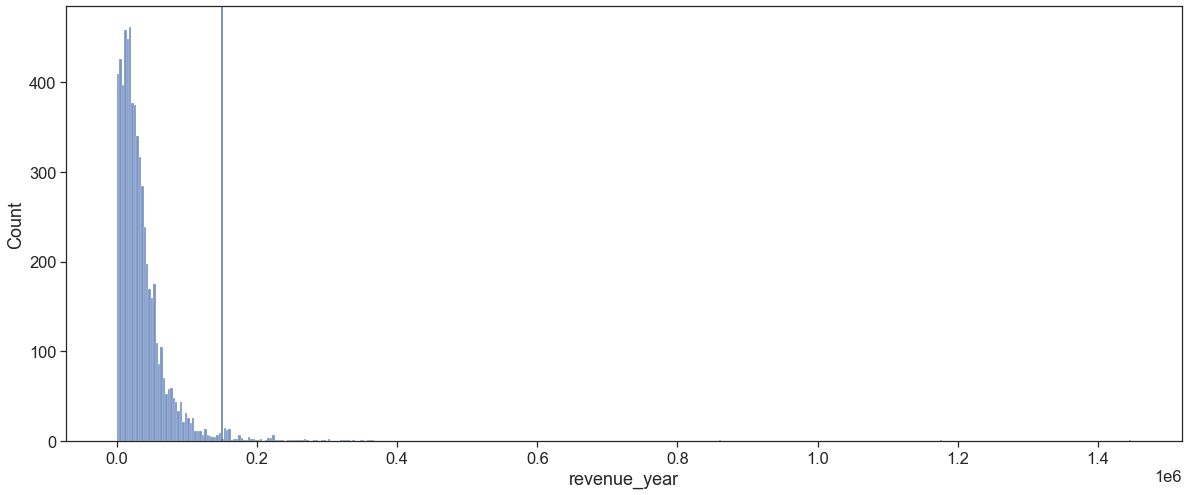

In [5]:
plt.figure(figsize=(20,8))
p2=sns.histplot(data=df_vis, x='revenue_year')
p2.axvline(150000)
plt.show()

<b>Plot of the distribution of "accommodates:
- the overall distribution is quite similar between the two cities
- Boston has more single person listings
- after 8 persons there are only few listings, which is why I chose to put a cut-off there

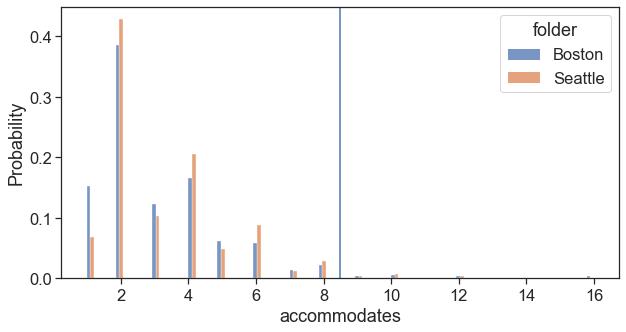

In [6]:
plt.figure(figsize=(10,5))
p3=sns.histplot(data=df_vis, x="accommodates", hue="folder", stat="probability", common_norm=False, multiple="dodge")
p3.axvline(8.5)
plt.show()

<b>Plot of listings per "neighbourhood_cleansed" and "property_type":
- in the first trials to apply a linear regression model the neighbourhoods with few listings disturbed the modelling
- I defined a cut-off at a minimum of 10 listings for a neighbourhood/p to be included

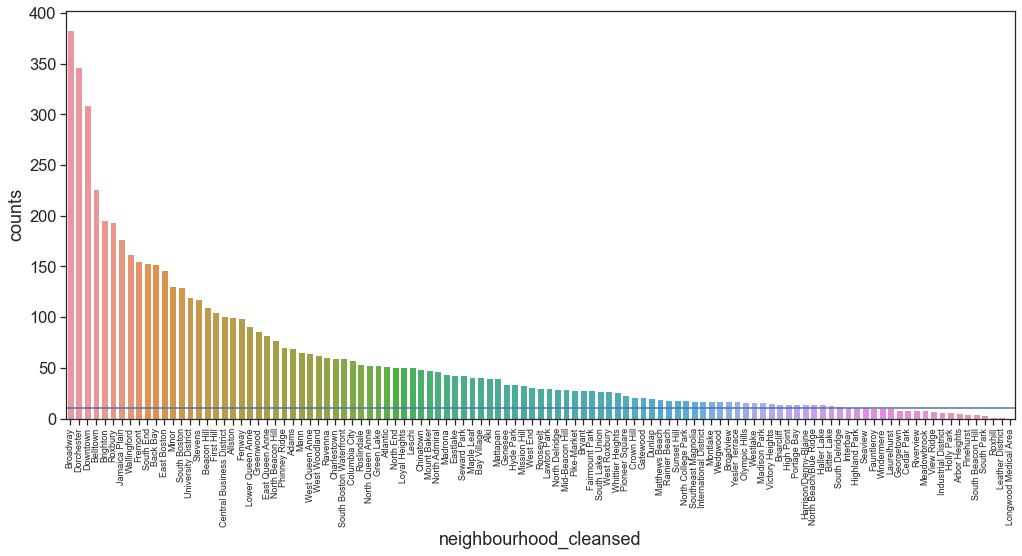

In [7]:
neighbourhoods=df_vis['neighbourhood_cleansed'].value_counts().reset_index().rename(columns={'index':'neighbourhood_cleansed', 'neighbourhood_cleansed':'counts'})
plt.figure(figsize=(17,7.5))
p3=sns.barplot(x="neighbourhood_cleansed", y="counts", data=neighbourhoods)
p3.axhline(10)
plt.xticks(rotation=90, fontsize=9)
plt.show()

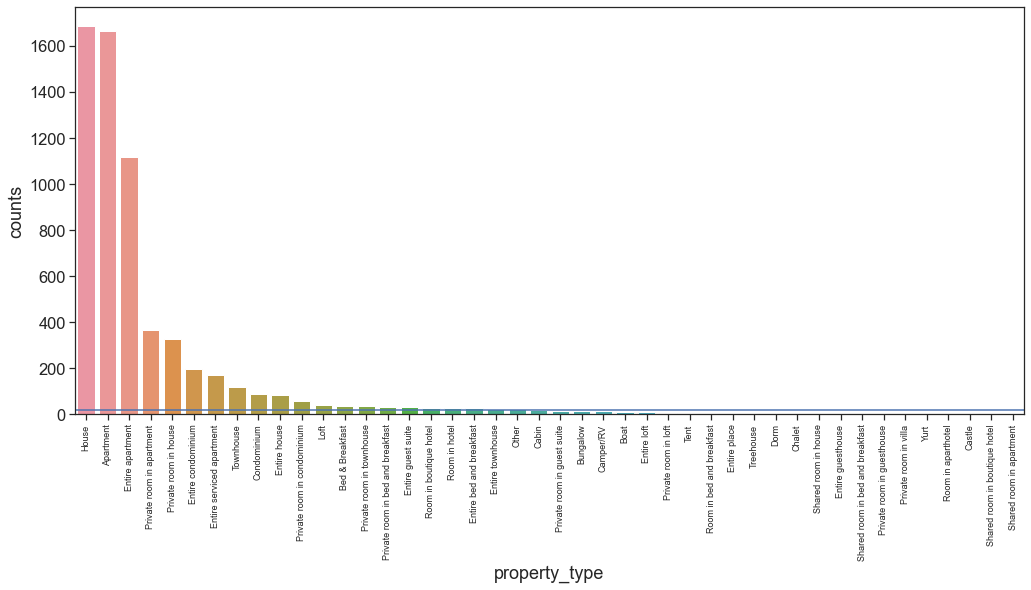

In [8]:
property_type=df_vis['property_type'].value_counts().reset_index().rename(columns={'index':'property_type', 'property_type':'counts'})
plt.figure(figsize=(17,7.5))
p3=sns.barplot(x="property_type", y="counts", data=property_type)
p3.axhline(20)
plt.xticks(rotation=90, fontsize=9)
plt.show()

## <b>Setting up the model and applying it to the data

I now applied a <b>linear modelling</b> to my dataset df to find the strongest influences to yearly revenue
- for that I dropped all columns that are duplicate (e.g., folder) or contain revenue information
- the r-squared is quite alright with about <b>0.73</b> for this

In [11]:
target='revenue_year'
drop=['revenue_year',1,2,3,4,5,6,7,8,9,10,11,12,'folder_Boston','folder_Seattle','revenue_month_mean']
lm_model_rev, X_train_rev=dp.regression_model(df,target, drop)

The r-squared score for your model was 0.7282541880332372 on 1369 values.


First I looked at the features that <b>positively</b> influence my revenue:

The answer is not surprising for any realtor... <b>location, location, location</b>

The top 20 features that <b>negatively</b> influence my revenue are property types and location

## <b> Evalution of the results and their interpretation

In [12]:
#Use the function and look at the top 30 
coef_df_rev = dp.coef_weights(lm_model_rev.coef_, X_train_rev)
coef_df_rev.nlargest(20,'coefs')

,est_int,coefs,abs_coefs
83,neighbourhood_cleansed_North End,33334.808326,33334.808326
36,neighbourhood_cleansed_Chinatown,28276.374520,28276.374520
25,neighbourhood_cleansed_Bay Village,25522.585635,25522.585635
98,neighbourhood_cleansed_South Boston Waterfront,23383.979001,23383.979001
40,neighbourhood_cleansed_Downtown,21705.050620,21705.050620
24,neighbourhood_cleansed_Back Bay,21430.084558,21430.084558
100,neighbourhood_cleansed_South End,20252.810183,20252.810183
26,neighbourhood_cleansed_Beacon Hill,20010.732735,20010.732735
97,neighbourhood_cleansed_South Boston,19650.562849,19650.562849
34,neighbourhood_cleansed_Central Business District,16758.623286,16758.623286


In [13]:
coef_df_rev.nsmallest(20,'coefs')

,est_int,coefs,abs_coefs
140,property_type_Room in hotel,-19875.497617,19875.497617
122,property_type_Entire bed and breakfast,-14331.954623,14331.954623
132,property_type_Private room in apartment,-12197.914801,12197.914801
135,property_type_Private room in condominium,-10854.299804,10854.299804
126,property_type_Entire house,-10494.200285,10494.200285
136,property_type_Private room in house,-9252.567699,9252.567699
121,property_type_Entire apartment,-9134.404561,9134.404561
123,property_type_Entire condominium,-8470.919204,8470.919204
124,property_type_Entire guest suite,-8350.826935,8350.826935
56,neighbourhood_cleansed_High Point,-8025.297476,8025.297476


The top influences were all neighbourhoods, but I also wanted to know which of the review scores 
- location is also here the number 1
- cleanliness is number 2

In [14]:
coef_df_rev[coef_df_rev['est_int'].str[0:6]=='review'].sort_values('coefs', ascending=False)

,est_int,coefs,abs_coefs
11,review_scores_location,1495.065573,1495.065573
1,review_scores_cleanliness,404.069814,404.069814
9,review_scores_checkin,85.744441,85.744441
7,review_scores_accuracy,56.447589,56.447589
12,review_scores_rating,54.194033,54.194033
14,review_scores_communication,-159.214128,159.214128
4,reviews_per_month,-433.590655,433.590655
15,review_scores_value,-801.307590,801.307590


The description of the listing or the neighbourhood seems rather unimportant. Only the number of listed amenities seems to count. A rather long name seems to be more repelling than inviting.

In [15]:
coef_df_rev[coef_df_rev['est_int'].str[-5:]=='count'].sort_values('coefs', ascending=False)

,est_int,coefs,abs_coefs
16,amenities_count,6.694732,6.694732
19,neighborhood_overview_count,1.005933,1.005933
17,description_count,0.526001,0.526001
18,name_count,-53.379009,53.379009


In [16]:
coef_df_rev[coef_df_rev['est_int'].str[0:5]=='prope'].sort_values('coefs', ascending=False)

,est_int,coefs,abs_coefs
138,property_type_Room in boutique hotel,9.665265e+03,9.665265e+03
131,property_type_Other,6.797785e+02,6.797785e+02
117,property_type_Apartment,4.091070e+02,4.091070e+02
119,property_type_Cabin,2.245898e+02,2.245898e+02
139,property_type_Room in hostel,9.094947e-13,9.094947e-13
134,property_type_Private room in bungalow,0.000000e+00,0.000000e+00
142,property_type_Shared room in townhouse,0.000000e+00,0.000000e+00
141,property_type_Shared room in condominium,0.000000e+00,0.000000e+00
125,property_type_Entire home/apt,-3.637979e-12,3.637979e-12
120,property_type_Condominium,-2.334423e+02,2.334423e+02


In [22]:
coef_df_rev[coef_df_rev['est_int'].str[0:5]=='accom'].sort_values('coefs', ascending=False)

,est_int,coefs,abs_coefs
10,accommodates,2366.449583,2366.449583


The plot of the yearly revenue by neighbourhood reflects the results of the linear model

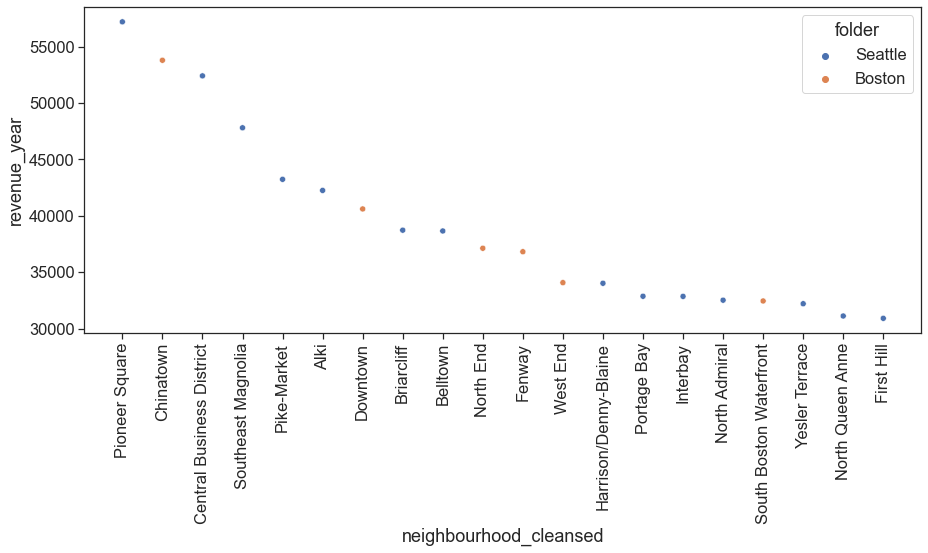

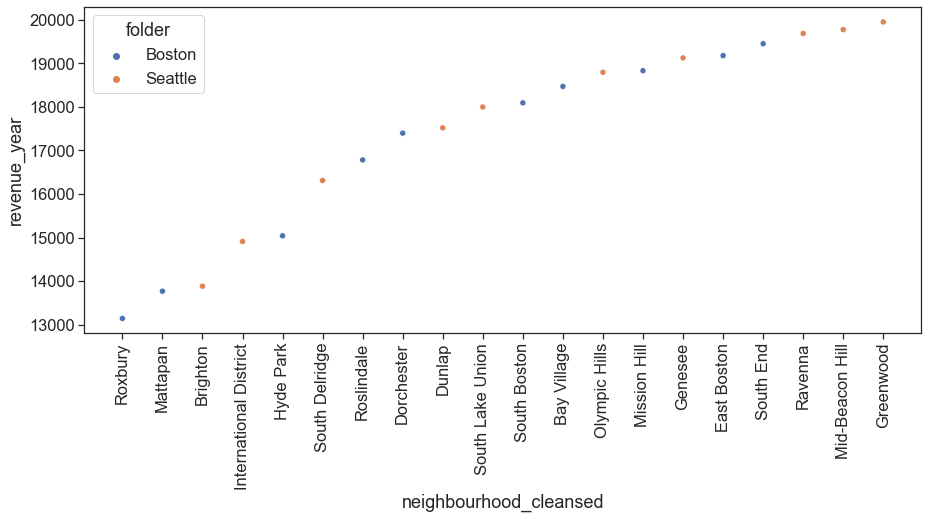

In [21]:
df_2=df_plot.groupby(by=['neighbourhood_cleansed','folder'], as_index=False)['revenue_year'].median()
plt.figure(figsize=(15,6))
p6=sns.scatterplot(data=df_2.nlargest(20,'revenue_year'), x="neighbourhood_cleansed", y="revenue_year", hue="folder")
plt.xticks(rotation=90)
plt.show()
plt.figure(figsize=(15,6))
p7=sns.scatterplot(data=df_2.nsmallest(20,'revenue_year'), x="neighbourhood_cleansed", y="revenue_year", hue="folder")
plt.xticks(rotation=90)
plt.show()

How do Boston and Seattle compare in the average revenue per month over a year?

In [18]:
df_plot_month=df_plot.merge(calendar_stats, left_on=['id','folder'],right_on=['listing_id','folder'])
df_plot_month_2=df_plot_month.groupby(by=['month','folder'], as_index=False)['revenue'].median()

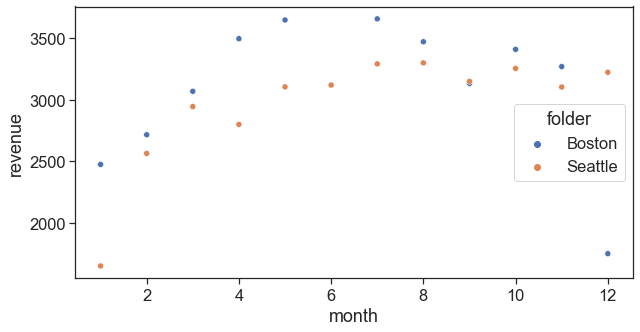

In [19]:
plt.figure(figsize=(10,5))
p8=sns.scatterplot(data=df_plot_month_2, x="month", y="revenue", hue="folder")
plt.show()

<b>df_plot</b> is the version of df_vis that has all those previous cut-offs applied

In [9]:
df_plot=df_vis[(df_vis['revenue_year']<150000)&(df_vis['accommodates']<8.5)]
neighbourhoods=df_plot['neighbourhood_cleansed'].value_counts().reset_index()
remove_list=neighbourhoods[neighbourhoods['neighbourhood_cleansed']<10]['index'].to_list()
df_plot=df_plot[~df_plot['neighbourhood_cleansed'].isin(remove_list)]

In this plot the <b>revenue_year</b> is plotted against the number of people a listing <b>accommodates</b>
- Up to 8 people it is a near linear function
- the slope of it is not 1 though
- therefore you can expect more revenue per person for smaller listings

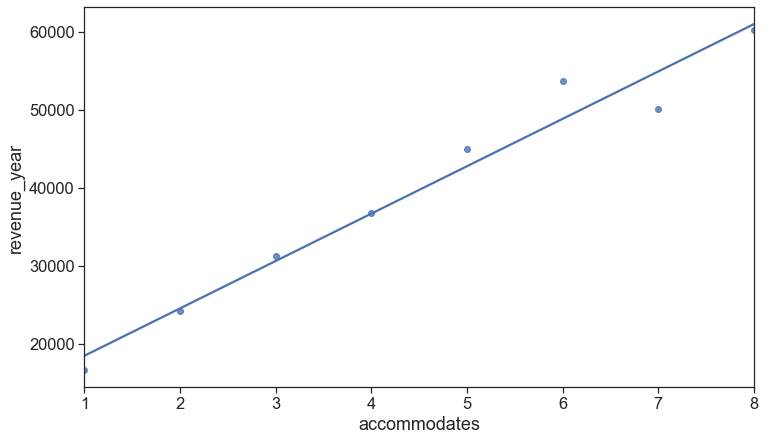

In [10]:
plt.figure(figsize=(12,7))
p5=sns.regplot(data=df_plot.groupby(by=['accommodates'], as_index=False)['revenue_year'].mean(), x="accommodates", y="revenue_year",ci=None)#, hue="folder")
plt.show()